# Calculate 2D arrival time maps for each shelf basin

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import time
from datetime import datetime
from dask import dataframe
from scipy.optimize import leastsq

import matplotlib.pyplot as plt

from dask.distributed import Client
import memory_profiler

import warnings
warnings.filterwarnings("ignore")

In [5]:
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[0] )
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
import custom_functions as cf

In [6]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 18,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35727,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 18
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:39985,Total threads: 3
Dashboard: /proxy/34443/status,Memory: 33.33 GiB
Nanny: tcp://127.0.0.1:35201,


#### Define custom functions

In [4]:
def geolocate_basin(ds, basinmask): #THIS IS ONLY FOR BASIN MAP (Not Particles)
    """
    Use basinmask to add ocean basin id to dataset
    """
    
    ds['basin'] = basinmask.sel(yu_ocean=ds.lat, xu_ocean=ds.lon, method='nearest').basins.drop_vars(['yu_ocean','xu_ocean'])
    
    return ds

# Inverse Gaussian (scaled)
def inversegaussian(x, Gamma, Delta, Scaling):
    inversegaussian = []
    for i in range(x.size):
        inversegaussian += [Scaling*(((Gamma**3)/(4 * np.pi * (Delta**2) * (x[i]**3)))**(0.5))
                            * np.exp(((-Gamma)*((x[i]-Gamma)**2))/(4*(Delta**2)*x[i]))]
    return np.array(inversegaussian)

# Residual Calculation for least squares
def res(p, y, x):
    Gam, Del, Sca = p
    y_fit = inversegaussian(x, Gam, Del, Sca)
    err = y - y_fit
    return err

#### Load required data

In [5]:
# Open Antarctic basins file
antarctic_basins = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc')

# Open initial particle parameters file
startfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/CircumAntarcticParticles_initial_values.nc'
ref = xr.open_dataset(startfile, decode_cf=False).drop_vars(['shelf_exit_lat', 'shelf_exit_lon', 'shelf_exit_z', 
                                                             'shelf_exit_S', 'shelf_exit_T', 'z', 'temp', 'salt', 
                                                             'shelf_weighted_val', 'shelf', 'lat', 'lon',
                                                            ]).load()

# Define particle files
npart = 130146
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/xarray_files/traj_chunked_basin/'
files = sorted(glob(datadir+'CircumAntarcticParticles_*.nc')) 

## open complete particle dataset
ds = xr.open_mfdataset(files, decode_cf=False).drop_vars(['psal','thermo','mixedlayershuffle', 'mldepth', 
                                                          'unbeachCount', 'z', 'basin', 'shelf','basin_ZonalConn',])

print(ds.nbytes/1000**3)

115.0719818


In [6]:
print(antarctic_basins.region.values)
print(antarctic_basins.basin_lookup.values)

['East Antarctica 01' 'East Antarctica 02' 'Ross Sea' 'West Antarctica'
 'West Antarctic Peninsula' 'Weddell Sea' 'Southern Ocean']
[  2.   3.   4.   5.   6.   7. 100.]


Select out every second particle to assess particle transport sensitivity. 

In [7]:
idx = np.arange(0,9500658,2)
ref = ref.isel(trajectory = idx)
ds = ds.isel(trajectory = idx)

#### Calculate 2D maps of arrival time

First define histogram parameters. 

In [10]:
# Size of bins for histograms
ntime = 21
total_months = ntime*12
bin_months = 6
delta_time_bin = ntime/total_months*bin_months

# Bins for histograms
time_bin = np.arange(0,ntime,delta_time_bin)

# X in timestep increments
x = time_bin[:-1]
x_long = np.arange(delta_time_bin, ntime*3, delta_time_bin)

# Convert X to years and center points on middle of timesteps
x_years = (x + delta_time_bin/2.0) 
x_years_long = (x_long + delta_time_bin/2.0)

# Initial guess for Gam, Del, Sca
Gam, Del, Sca = [20, 50, 1000000] #5, 30
p = [Gam, Del, Sca] # Initial guesses for leastsq
y_init = inversegaussian(x_years, Gam, Del, Sca) # Initial Guess

# set lat and lon bins
dlon = 1
dlat = 0.5
lat_S, lat_N = -81, -48
lon_W, lon_E = -280, 80
#lonarray = np.arange(lon_W, lon_E, dlon)
#latarray = np.arange(lat_S, lat_N, dlat)
xarange = np.arange(lon_W, lon_E+dlon, dlon)
yarange = np.arange(lat_S, lat_N+dlat, dlat)
xmid = (xarange[1:]+xarange[:-1])/2. # longitude midpoints
ymid = (yarange[1:]+yarange[:-1])/2. # latitude midpoints

# create basin map to test if timemap is in ocean or not
basinmap = np.zeros((len(ymid), len(xmid)))
basinmap = xr.DataArray(basinmap, coords=[ymid, xmid], dims=["lat", "lon"])
basinmap = geolocate_basin(basinmap, antarctic_basins)

Now loop through each basin and save 2D timemap arrays to file. 

In [ ]:
%%time
# Loop through each basin and save to 2Dpxy file
for basinid in antarctic_basins.basin_lookup[1:4]:
    print(basinid.values)
    # create empty arrays for timemap
    timemap_peak = np.zeros((len(ymid), len(xmid)))
    timemap_peak = xr.DataArray(timemap_peak, coords=[ymid, xmid], dims=["lat", "lon"])
    timemap_peak.attrs["Long name"] = "Peak arrival time since release to reach specific grid box - weighted by transport"
    timemap_peak.attrs["Units"] = "Years"
    
    timemap_peak_gaussian = np.zeros((len(ymid), len(xmid)))
    timemap_peak_gaussian = xr.DataArray(timemap_peak_gaussian, coords=[ymid, xmid], dims=["lat", "lon"])
    timemap_peak_gaussian.attrs["Long name"] = "Peak arrival time based on analytical inverse gaussian TTD fit - weighted by transport"
    timemap_peak_gaussian.attrs["Units"] = "Years"
    
    timemap_peak_unweighted_gaussian =  np.zeros((len(ymid), len(xmid)))
    timemap_peak_unweighted_gaussian = xr.DataArray(timemap_peak_unweighted_gaussian, coords=[ymid, xmid], dims=["lat", "lon"])
    timemap_peak_unweighted_gaussian.attrs["Long name"] = "Peak arrival time based on analytical inverse gaussian TTD fit - unweighted, just based on particle count"
    timemap_peak_unweighted_gaussian.attrs["Units"] = "Years"
           
    timemap_mean = np.zeros((len(ymid), len(xmid)))
    timemap_mean = xr.DataArray(timemap_mean, coords=[ymid, xmid], dims=["lat", "lon"])
    timemap_mean.attrs["Long name"] = "Mean time since release to reach specific grid box"
    timemap_mean.attrs["Units"] = "Days"
    
    timemap_median = np.zeros((len(ymid), len(xmid)))
    timemap_median = xr.DataArray(timemap_median, coords=[ymid, xmid], dims=["lat", "lon"])
    timemap_median.attrs["Long name"] = "Median time since release to reach specific grid box"
    timemap_median.attrs["Units"] = "Days"
    
    # set land cells to nan
    timemap_peak = timemap_peak.where(basinmap.basin > 0, np.nan)
    timemap_peak_gaussian = timemap_peak_gaussian.where(basinmap.basin > 0, np.nan)
    timemap_peak_unweighted_gaussian = timemap_peak_unweighted_gaussian.where(basinmap.basin > 0, np.nan)
    timemap_mean = timemap_mean.where(basinmap.basin > 0, np.nan)
    timemap_median = timemap_median.where(basinmap.basin > 0, np.nan)
    
    # select out particle trajectories for this basin
    traj = np.where(ref.basin == basinid.values)[0]
    
    # subset ds for basin and convert to dataframe
    print("loading basin dataset...")
    dfloop = ds.isel(trajectory = traj).to_dataframe()
    print("dropping NaNs...")
    dfloop.dropna(subset = ["lat", "lon"], inplace=True)
    
    # convert transport and releasetime to df
    print("convert transport and releasetime to df...")
    refloop = ref.isel(trajectory=traj).to_dataframe().reset_index().drop(columns = ['basin', 'shelf_exit_indx']) #RELEASE TIME IS IN DAYS!!!!!!!

    for j, lat in enumerate(yarange[:-1]): #loop through latitude bins
        print(j,lat)
        # create latitude dataframe subset
        dflattmp = dfloop[(dfloop['lat'] >= lat) & (dfloop['lat'] < (lat+dlat))]
        dflattmp = dflattmp.reset_index()
        
        # merge transport and release_time values into dataframe
        dflattmp = pd.merge(dflattmp, np.abs(refloop), 
                     left_on = 'trajectory', 
                     right_on = 'trajectory', 
                     how='left')
        dflattmp['crossing_time'] = dflattmp['time'] - dflattmp['release_time']*24*60*60

        for i, lon in enumerate(xarange[:-1]):  #loop through longitude bins
            if np.isnan(basinmap.basin[j,i]):
                continue
            else:
                dflontmp = dflattmp[(dflattmp.lon>=lon) & (dflattmp.lon<(lon+dlon))]
                if dflontmp.shape[0] > 0:                    
                    # add mean and median time to map arrays
                    timemap_mean[j,i] = dflontmp.groupby('trajectory').first().crossing_time.mean(skipna=True)/60/60/24 # converts to days
                    timemap_median[j,i] = dflontmp.groupby('trajectory').first().crossing_time.median(skipna=True)/60/60/24 # converts to days
                    n, x = np.histogram(dflontmp.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
                            bins=time_bin, weights= dflontmp.groupby('trajectory').first().trans.values)
                    m = n.max()
                    maxval = np.where(n == m)[0]
                    pa = (x[maxval] + x[maxval+1])/2
                    timemap_peak[j,i] = pa[0]
                    
                    # transport weighted inverse gaussian method
                    y_data = np.histogram(dflontmp.groupby('trajectory').first().crossing_time.values/60/60/24/365,
                                          bins=time_bin, weights= dflontmp.groupby('trajectory').first().trans.values)
                    # Least squares
                    plsq = leastsq(res, p, args = (y_data[0], x_years))
                    # Fitted inverse gaussian distribution, optimizing three parameters
                    y_est_long = inversegaussian(x_years_long, plsq[0][0], plsq[0][1], plsq[0][2])
                    # Index of max of the distribution
                    argmax_dist = np.argmax(y_est_long)
                    # save time of peak to array
                    timemap_peak_gaussian[j,i] = x_years_long[argmax_dist]
                    
                    # unweighted inverse gaussian method (particle count)
                    y_data = np.histogram(dflontmp.groupby('trajectory').first().crossing_time.values/60/60/24/365,
                                          bins=time_bin,)
                    # Least squares
                    plsq = leastsq(res, p, args = (y_data[0], x_years))
                    # Fitted inverse gaussian distribution, optimizing three parameters
                    y_est_long = inversegaussian(x_years_long, plsq[0][0], plsq[0][1], plsq[0][2])
                    # Index of max of the distribution
                    argmax_dist = np.argmax(y_est_long)
                    # save time of peak to array
                    timemap_peak_unweighted_gaussian[j,i] = x_years_long[argmax_dist]
                    

    timemap = xr.Dataset(data_vars=dict(mean_arrival=timemap_mean,  
                                        median_arrival=timemap_median, 
                                        peak_arrival=timemap_peak, 
                                        peak_gaussian=timemap_peak_gaussian, 
                                        peak_unweighted_gaussian = timemap_peak_unweighted_gaussian))
    timemap = timemap.drop('basin')
    timemap.attrs['History'] = 'Created {}.'.format(datetime.now().strftime("%Y-%m-%d"))
    outfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dtime/sensitivityTest_2Dtimemap_6mobins_coarsebasin_{:02d}_initial_G-{}_D-{}_Sca-{}_allbins.nc'.format(int(basinid.values), Gam, Del, Sca)
    # Save to netCDF
    print("Saving to netCDF file", outfile)
    encod={}
    for var in timemap.data_vars:
        encod[var]={'zlib':True}
    timemap.to_netcdf(outfile)

3.0
loading basin dataset...
dropping NaNs...
convert transport and releasetime to df...
0 -81.0
1 -80.5
2 -80.0
3 -79.5
4 -79.0
5 -78.5
6 -78.0
7 -77.5
8 -77.0
9 -76.5
10 -76.0
11 -75.5
12 -75.0
13 -74.5
14 -74.0
15 -73.5
16 -73.0
17 -72.5
18 -72.0
19 -71.5
20 -71.0
21 -70.5
22 -70.0
23 -69.5
24 -69.0
25 -68.5
26 -68.0
27 -67.5
28 -67.0
29 -66.5
30 -66.0
31 -65.5
32 -65.0
33 -64.5
34 -64.0
35 -63.5
36 -63.0
37 -62.5
38 -62.0
39 -61.5
40 -61.0
41 -60.5
42 -60.0
43 -59.5
44 -59.0
45 -58.5
46 -58.0
47 -57.5
48 -57.0
49 -56.5
50 -56.0
51 -55.5
52 -55.0
53 -54.5
54 -54.0
55 -53.5
56 -53.0
57 -52.5
58 -52.0
59 -51.5
60 -51.0
61 -50.5
62 -50.0
63 -49.5
64 -49.0
65 -48.5
Saving to netCDF file /g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dtime/sensitivityTest_2Dtimemap_6mobins_coarsebasin_03_initial_G-20_D-50_Sca-1000000_allbins.nc
4.0
loading basin dataset...
dropping NaNs...
convert transport and releasetime to df...
0 -81.0
1 -80.5
2 -80.0
3 -79.5
4 -79.0
5 -78.5
6 -78.0
7 -77.5
8 -

## Plot half release vs full release comparison

In [56]:
# Reference 2Dpxy data
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/'
pxyfiles = sorted(glob(datadir+'2Dpxy_basin_*_1x0.5.nc')) 

# Reference 2D time data
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dtime/'
timefiles = sorted(glob(datadir+'2Dtimemap_6mobins_coarsebasin_*_initial_G-20_D-50_Sca-1000000_allbins.nc')) 
sensitivity_timefiles = sorted(glob(datadir+'sensitivityTest_2Dtimemap_6mobins_coarsebasin_*.nc')) 

# Open Antarctic basins file
antarctic_basins = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc')

# open starting param file
startfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/CircumAntarcticParticles_initial_values.nc'
ref = xr.open_dataset(startfile, decode_cf=False)

# open parcticle datset
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/xarray_files/traj_chunked_basin/'
files = sorted(glob(datadir+'CircumAntarcticParticles_*.nc')) 
## open complete particle dataset
parcelsds = xr.open_mfdataset(files, decode_cf=False).drop_vars(['psal','thermo','mixedlayershuffle','mldepth', 
                                                          'unbeachCount', 'basin', 'z','basin_ZonalConn'])#.load()
#parcelsds

Select out every second particle to assess particle transport sensitivity. 

In [15]:
idx = np.arange(0,9500658,2)
ref = ref.isel(trajectory = idx)
parcelsds = parcelsds.isel(trajectory = idx)

#### Calculate TTD's and save to file

Based on rapidly melting ice shelf locations. 

Define functions to calculate ttd's

In [19]:
def ttd_lon(ds, startlon, endlon, dlon, nbins):
    ids = np.where(ref.lon == startlon)[0]
    trans_start = np.abs(ref.trans[ids]).sum().values
    dssub = ds.isel(trajectory = ids).load()
    refsub = ref.isel(trajectory = ids).drop_vars(['lat', 'lon', 'z', 'basin','shelf',
                                                  'shelf_exit_T', 'shelf_exit_S', 'shelf_exit_indx',
                                                  'shelf_exit_lon', 'shelf_exit_lat', 'shelf_exit_z', 
                                                  'shelf_weighted_val', 'temp', 'salt']).load().to_dataframe().reset_index()
    dfsub = dssub.to_dataframe()
    dfsub.dropna(subset = ["lat", "lon"], inplace=True)
    dfsub = dfsub[(dfsub['lon'] <= endlon) & (dfsub['lon']> endlon-dlon) & (dfsub['shelf'] == 1)]
    dfsub = dfsub.reset_index()
        
    # merge transport and release_time values into dataframe
    dfsub = pd.merge(dfsub, np.abs(refsub), 
                 left_on = 'trajectory', 
                 right_on = 'trajectory', 
                 how='left')
    dfsub['crossing_time'] = dfsub['time'] - dfsub['release_time']*24*60*60
    dfsub['trans_pct'] = (dfsub['trans'] / trans_start) * 100
    n, x = np.histogram(dfsub.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
                        bins=nbins, 
                        # commout out line below for unweighted ttd
                        weights= dfsub.groupby('trajectory').first().trans.values,
                       )
    m = n.max()
    maxval = np.where(n == m)[0]
    ttd = (x[maxval] + x[maxval+1])/2    

    return dfsub#,ttd, n, x

def ttd_lon_Ross(ds, startlon, endlon, dlon, nbins, basinid):
    ids = np.where((ref.lon == startlon) & (ref.basin == basinid))[0]
    trans_start = np.abs(ref.trans[ids]).sum().values
    dssub = ds.isel(trajectory = ids).load()
    refsub = ref.isel(trajectory = ids).drop_vars(['lat', 'lon', 'z', 'basin','shelf',
                                                  'shelf_exit_T', 'shelf_exit_S', 'shelf_exit_indx',
                                                  'shelf_exit_lon', 'shelf_exit_lat', 'shelf_exit_z', 
                                                  'shelf_weighted_val', 'temp', 'salt']).load().to_dataframe().reset_index()
    dfsub = dssub.to_dataframe()
    dfsub.dropna(subset = ["lat", "lon"], inplace=True)
    dfsub = dfsub[(dfsub['lon'] <= endlon) & (dfsub['lon']> endlon-dlon) & (dfsub['shelf'] == 1)]
    dfsub = dfsub.reset_index()
        
    # merge transport and release_time values into dataframe
    dfsub = pd.merge(dfsub, np.abs(refsub), 
                 left_on = 'trajectory', 
                 right_on = 'trajectory', 
                 how='left')
    dfsub['crossing_time'] = dfsub['time'] - dfsub['release_time']*24*60*60
    dfsub['trans_pct'] = (dfsub['trans'] / trans_start) * 100
    n, x = np.histogram(dfsub.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
                        bins=nbins, 
                        # commout out line below for unweighted ttd
                        weights= dfsub.groupby('trajectory').first().trans.values,
                       )
    m = n.max()
    maxval = np.where(n == m)[0]
    ttd = (x[maxval] + x[maxval+1])/2    

    return dfsub#,ttd, n, x

def ttd_lat(ds, startlon, endlat, dlat, nbins):
    ids = np.where(ref.lon == startlon)[0]
    trans_start = np.abs(ref.trans[ids]).sum().values
    dssub = ds.isel(trajectory = ids).load()
    refsub = ref.isel(trajectory = ids).drop_vars(['lat', 'lon', 'z', 'basin','shelf',
                                                  'shelf_exit_T', 'shelf_exit_S', 'shelf_exit_indx',
                                                  'shelf_exit_lon', 'shelf_exit_lat', 'shelf_exit_z', 
                                                  'shelf_weighted_val', 'temp', 'salt']).load().to_dataframe().reset_index()
    dfsub = dssub.to_dataframe()
    dfsub.dropna(subset = ["lat", "lon"], inplace=True)
    dfsub = dfsub[(dfsub['lat'] >= endlat) & (dfsub['lat']<endlat+dlat) & (dfsub['shelf'] == 1) 
                  & (dfsub['lon']>=-67) & (dfsub['lon']< -45)]
    dfsub = dfsub.reset_index()
        
    # merge transport and release_time values into dataframe
    dfsub = pd.merge(dfsub, np.abs(refsub), 
                 left_on = 'trajectory', 
                 right_on = 'trajectory', 
                 how='left')
    dfsub['crossing_time'] = dfsub['time'] - dfsub['release_time']*24*60*60
    dfsub['trans_pct'] = (dfsub['trans'] / trans_start) * 100
    n, x = np.histogram(dfsub.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
                        bins=nbins, 
                        # commout out line below for unweighted ttd
                        weights= dfsub.groupby('trajectory').first().trans.values,
                       )
    m = n.max()
    maxval = np.where(n == m)[0]
    ttd = (x[maxval] + x[maxval+1])/2    

    return dfsub#, n, x

In [20]:
%%time
print("EA-W")
df1 = ttd_lon(parcelsds, 72, -48, 1, 80) # Amery Ice Shelf to Ronne-Filchner Ice Shelf
df2 = ttd_lat(parcelsds, 72, -67.5, 0.5, 80) # Amery Ice Shelf to Larsen-C Ice Shelf
df1.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_072E-48W_AIS-FRIS.csv')
df2.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_072E-675S_AIS-LRC.csv')

EA-W
CPU times: user 56.1 s, sys: 13.1 s, total: 1min 9s
Wall time: 4min 26s


In [21]:
%%time
print("EA-E")
df3 = ttd_lon(parcelsds, 117-360, 70, 1, 80) # Totten Glacier to Cape Darnley
df4= ttd_lon(parcelsds, 117-360, -48, 1, 80) # Totten Glacier to Ronne-Filchner Ice Shelf
df3.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_117E-70E_TG-CD.csv')
df4.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_117E-48W_TG-FRIS.csv')

EA-E
CPU times: user 36.5 s, sys: 9.26 s, total: 45.8 s
Wall time: 2min 3s


In [22]:
%%time
print("RS")
df5 = ttd_lon_Ross(parcelsds, 167-360, 145-360, 1, 80, 4.0) # Ross Ice Shelf (Terra Nova Bay) to Mertz Polynya
df6 = ttd_lon_Ross(parcelsds, 167-360, 70, 1, 80, 4.0) # Ross Ice Shelf (Terra Nova Bay) to Cape Darnley
df5.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_167E-145E_RIS-MP.csv')
df6.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_167E-70E_RIS-CD.csv')

RS
CPU times: user 1min 3s, sys: 18.7 s, total: 1min 21s
Wall time: 2min 37s


In [23]:
%%time
print("WA")
df7 = ttd_lon(parcelsds, -103, 167-360, 1, 80)  # Pine Island Glacier to Ross Ice Shelf (Terra Nova Bay)
df8 = ttd_lon(parcelsds, -103, 145-360, 1, 80) # Pine Island Glacier to Mertz Polynya
df7.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_78W-167E_PIG-RIS.csv')
df8.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_78W-145E_PIG-MP.csv')

WA
CPU times: user 55.7 s, sys: 15.4 s, total: 1min 11s
Wall time: 2min 24s


In [24]:
print("WS")
df9 = ttd_lat(parcelsds, -48, -67.5, 0.5, 80) # Ronne-Filchner Ice Shelf to Larsen-C
df10 = ttd_lon(parcelsds, -48, -77, 1, 80) # Ronne-Filchner Ice Shelf to Stange Ice Shelf, Bell Sea
df9.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_48W-675S_FRIS-LRC.csv')
df10.to_csv('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_48W-77W_FRIS-STIG.csv')

WS


#### Read in calculated TTD data

In [26]:
dffiles = sorted(glob('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/sensitivityTest_TTD_*.csv'))

# EA-W
df1 = pd.read_csv(dffiles[0])
df2 = pd.read_csv(dffiles[1])
# EA-E
df3 = pd.read_csv(dffiles[3])
df4 = pd.read_csv(dffiles[2])
# RS
df5 = pd.read_csv(dffiles[4])
df6 = pd.read_csv(dffiles[5])
# WA
df7 = pd.read_csv(dffiles[9])
df8 = pd.read_csv(dffiles[8])
# WS
df9 = pd.read_csv(dffiles[6])
df10 = pd.read_csv(dffiles[7])

Plot (roughly) TTDs. 

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6))
nbins=40
dbin = 0.5
nbins = np.arange(0,20+dbin, dbin)

n1, x1, _ = axes[0][0].hist(df1.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df1.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='b')
n2, x2, _ = axes[0][0].hist(df2.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df2.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='k')
n3, x3, _ = axes[0][1].hist(df3.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df3.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='b')
n4, x4, _ = axes[0][1].hist(df4.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df4.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='k')
n5, x5, _ = axes[0][2].hist(df5.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df5.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='b')
n6, x6, _ = axes[0][2].hist(df6.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df6.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='k')
n7, x7, _ = axes[1][0].hist(df7.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df7.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='b')
n8, x8, _ = axes[1][0].hist(df8.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df8.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='k')
n9, x9, _ = axes[1][1].hist(df9.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df9.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='b')
n10, x10, _ = axes[1][1].hist(df10.groupby('trajectory').first().crossing_time.values/60/60/24/365, 
             bins=nbins, weights= df10.groupby('trajectory').first().trans_pct.values, 
             histtype='step', color='k')

Print peak values. 

In [33]:
# East Antarctica - West
print('East Antarctica - West')
index_max = n1.argmax()
print('blue cross:',(x1[index_max] + x1[index_max+1])/2, 'years')
index_max = n2.argmax()
print('black cross:',(x2[index_max] + x2[index_max+1])/2, 'years')

# East Antarctica - East
print('East Antarctica - East')
index_max = n3.argmax()
print('blue cross:',(x3[index_max] + x3[index_max+1])/2, 'years')
index_max = n4.argmax()
print('black cross:',(x4[index_max] + x4[index_max+1])/2, 'years')

# Ross Sea
print('Ross Sea')
index_max = n5.argmax()
print('blue cross:',(x5[index_max] + x5[index_max+1])/2, 'years')
index_max = n6.argmax()
print('black cross:',(x6[index_max] + x6[index_max+1])/2, 'years')

# West Antarctica
print('West Antarctica')
index_max = n7.argmax()
print('blue cross:',(x7[index_max] + x7[index_max+1])/2, 'years')
index_max = n8.argmax()
print('black cross:',(x8[index_max] + x8[index_max+1])/2, 'years')

# Weddell Sea
print('Weddell Sea')
index_max = n9.argmax()
print('blue cross:', (x9[index_max] + x9[index_max+1])/2, 'years')
index_max = n10.argmax()
print('black cross:',(x10[index_max] + x10[index_max+1])/2, 'years')

East Antarctica - West
blue cross: 3.25 years
black cross: 4.25 years
East Antarctica - East
blue cross: 1.25 years
black cross: 4.25 years
Ross Sea
blue cross: 1.25 years
black cross: 3.25 years
West Antarctica
blue cross: 3.25 years
black cross: 4.75 years
Weddell Sea
blue cross: 1.25 years
black cross: 5.75 years


#### Define plotting functions

In [60]:
import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.patheffects as mpe
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

from palettable import scientific
import cmocean as cm

In [38]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
land_mask[300:, 800:1000] = 0
land_mask[355:,5:140] = 0
land_mask[225:, 1800:2000] = 0

yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)



# define land mask
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.2)

Ncontour = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/input/proj01/sea_level_contour_ryf9091_N_cutoff.nc')
basin_mask = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc')
basin_mask['basins'] = basin_mask.basins.where(basin_mask.basins != 100, np.nan)
plotmask01 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_02_EA01.nc')
plotmask02 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_03_EA02.nc')
plotmask03 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_04_Ross.nc')
plotmask04 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_05_WA.nc')
plotmask05 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_06_WAP.nc')
plotmask06 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_07_Weddell.nc')


# create discrete colormap
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)

# create colormap
cmap = discrete_cmap(20, base_cmap=scientific.sequential.LaJolla_10_r.mpl_colormap) #scientific.sequential.Batlow_10.mpl_colormap
cmap.set_under('w') ##acc2d9
cmap.set_over('papayawhip')

Set plot parameters. 

In [92]:
colors = ['k', 'k', 'k', 'k', 'k']
regions = ['EA-W', 'EA-E', 'RS', 'WA', 'WAP', 'WS']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)']
rsize=120
marker = 'o' #'*'
releaseedge='w'#'green'
releasefill = 'r'#'tomato'#'#31C33A' #'mediumturquoise'#'greenyellow'
ralph = 0.9
linewidth=2
basincol='r'#'#008B45'
basinalph = 0.7
lw = 1.6
starcol='green'
#alph = 0.3
#minpct = 0.5
outline=mpe.withStroke(linewidth=6, foreground='k')
dbin = 0.5
nbins = np.arange(0,21+dbin, dbin)
cross1 = (0,0.1,1,1)#'royalblue'#'deepskyblue'
cross1edge = 'w'
cross2 = 'k'#'dimgrey'  # #31C33A
cross2edge = 'w'
contourcol1 = 'gold'
contourcol2 = 'dimgrey'#'yellow'

histlinewidth=1.2
steptype = 'step'
alph1 = 1
alph2 = 0.9

cmap = cm.cm.ice._resample(11)

Define figure function

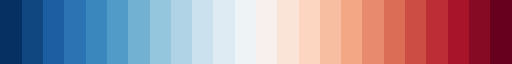

In [101]:
def plot_transect_locs(ax, lon):
    ids = np.where(ref.lon == lon)
    lat = ref.lat[ids].min()
    ax.scatter(lon, lat, marker=marker, s=rsize, facecolor=releasefill,edgecolor=releaseedge,linewidth=1.5,zorder=5,transform=ccrs.PlateCarree())
    return lon, lat

def contour_release_basin(ax1,ax3,ax5,ax7,ax9):
    lat = -80
    ax1.contour(xu_ocean[2180:2700], yu_ocean[:395], land_mask[:395,2180:2700].values, [0,1], zorder=2,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax1.contour(xu_ocean[2203:2300], yu_ocean[394:408], land_mask[394:408,2203:2300].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax1.contour(xu_ocean[2214:2300], yu_ocean[408:418], land_mask[408:418,2214:2300].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax1.contour(xu_ocean[2235:2300], yu_ocean[418:426], land_mask[418:426,2235:2300].values, [0,1], zorder=2,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax3.contour(xu_ocean[1431:2179], yu_ocean[:400], land_mask[:400,1431:2179].values, [0,1], zorder=2,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax5.contour(xu_ocean[820:1430], yu_ocean[:223], land_mask[:223,820:1430].values, [0,1], zorder=2,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax7.contour(xu_ocean[140:920], yu_ocean[225:], land_mask[225:,140:920].values, [0,1], zorder=2,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax9.contour(xu_ocean[2700:], yu_ocean, land_mask[:,2700:].values, [0,1], zorder=2,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax9.contour(xu_ocean[0:140], yu_ocean, land_mask[:,0:140].values, [0,1], zorder=2,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    
def add_legend(ax):
    legend_lines = [Line2D([0], [0], color=basincol, alpha=0.9, lw=lw+0.4),
                    Line2D([0], [0], color=contourcol1, alpha=0.9, lw=lw+0.4),
                    Line2D([0], [0], color=contourcol2, alpha=0.9, lw=lw+0.4, ls='--'),
                   ]
    ax.legend(legend_lines, ['Release sector','5 year contour','10 year contour'], loc='lower right', 
               fontsize=14, bbox_to_anchor=[0.9, 0.04], framealpha=0.35, fancybox=True)
    
def add_subplotlabels(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10):
    ax1.text(-0.09, 0.9, labels[0], fontweight='bold', fontsize=16, transform=ax1.transAxes)
    ax9.text(0.01, 0.9, 'East Antarctica - West', fontsize=14, transform=ax9.transAxes)
    ax3.text(-0.09, 0.9, labels[1], fontweight='bold', fontsize=16, transform=ax3.transAxes)
    ax7.text(0.01, 0.9, 'East Antarctica - East', fontsize=14, transform=ax7.transAxes)
    ax5.text(-0.09, 0.9, labels[2], fontweight='bold', fontsize=16, transform=ax5.transAxes)
    ax5.text(0.01, 0.9, 'Ross Sea', fontsize=14, transform=ax5.transAxes)
    ax7.text(-0.09, 0.9, labels[3], fontweight='bold', fontsize=16, transform=ax7.transAxes)
    ax3.text(0.01, 0.9, 'West Antarctica', fontsize=14, transform=ax3.transAxes)
    ax9.text(-0.09, 0.9, labels[4], fontweight='bold', fontsize=16, transform=ax9.transAxes)
    ax1.text(0.01, 0.9, 'Weddell Sea', fontsize=14, transform=ax1.transAxes)
    ax2.text(-0.18, 0.9, labels[5], fontweight='bold', fontsize=16, transform=ax2.transAxes)
    ax4.text(-0.18, 0.9, labels[6], fontweight='bold', fontsize=16, transform=ax4.transAxes)
    ax6.text(-0.18, 0.9, labels[7], fontweight='bold', fontsize=16, transform=ax6.transAxes)
    ax8.text(-0.18, 0.9, labels[8], fontweight='bold', fontsize=16, transform=ax8.transAxes)
    ax10.text(-0.18, 0.9, labels[9], fontweight='bold', fontsize=16, transform=ax10.transAxes)

def add_peak_arrival_time(ax2,ax4,ax6,ax8,ax10,param):
    if param is 'peak_gaussian':
        # sensitivity test values
        ax2.text(0.09, 0.9, '1.3', fontsize=14, color=cross1, transform=ax2.transAxes)
        ax2.text(0.26, 0.05, '5.8', fontsize=14, color=cross2,transform=ax2.transAxes)
        ax4.text(0.06, 0.9, '3.3', fontsize=14, color=cross1, transform=ax4.transAxes)
        ax4.text(0.285, 0.62, '4.8', fontsize=14, color=cross2,transform=ax4.transAxes)
        ax6.text(0.09, 0.9, '1.3', fontsize=14, color=cross1, transform=ax6.transAxes)
        ax6.text(0.14, 0.06, '3.3', fontsize=14, color=cross2,transform=ax6.transAxes)
        ax8.text(0.09, 0.9, '1.3', fontsize=14, color=cross1, transform=ax8.transAxes)
        ax8.text(0.17, 0.2, '4.3', fontsize=14, color=cross2,transform=ax8.transAxes)
        ax10.text(0.19, 0.9, '3.3', fontsize=14, color=cross1, transform=ax10.transAxes)
        ax10.text(0.24, 0.79, '4.3', fontsize=14, color=cross2,transform=ax10.transAxes)
    elif param is 'peak_unweighted_gaussian':
        ax2.text(0.09, 0.9, '1.3', fontsize=14, color=cross1, transform=ax2.transAxes)
        ax2.text(0.28, 0.35, '6.3', fontsize=14, color=cross2,transform=ax2.transAxes)
        ax4.text(0.04, 0.9, '3.3', fontsize=14, color=cross1, transform=ax4.transAxes)
        ax4.text(0.3, 0.9, '4.3', fontsize=14, color=cross2,transform=ax4.transAxes)
        ax6.text(0.09, 0.9, '1.3', fontsize=14, color=cross1, transform=ax6.transAxes)
        ax6.text(0.14, 0.58, '3.3', fontsize=14, color=cross2,transform=ax6.transAxes)
        ax8.text(0.09, 0.9, '1.3', fontsize=14, color=cross1, transform=ax8.transAxes)
        ax8.text(0.17, 0.35, '4.3', fontsize=14, color=cross2,transform=ax8.transAxes)
        ax10.text(0.19, 0.9, '2.8', fontsize=14, color=cross1, transform=ax10.transAxes)
        ax10.text(0.24, 0.7, '4.3', fontsize=14, color=cross2,transform=ax10.transAxes)
        
        
def add_release_and_destination_labels(ax1,ax3,ax5,ax7,ax9):
    ax1.text(-67.5, -78, 'Larsen-C IS', fontsize=12, color=cross1, rotation=90,transform=ccrs.PlateCarree())
    ax1.text(-90, -79.5, 'Stange IS', fontsize=12, color=cross2, transform=ccrs.PlateCarree())
    ax1.text(-57, -79.5, 'Ronne IS', fontsize=12, color=releasefill, transform=ccrs.PlateCarree())

    ax3.text(158.5-360, -79.5, 'Ross IS', fontsize=12, color=cross1, transform=ccrs.PlateCarree())
    ax3.text(134-360, -79.5, 'Mertz \nPolynya', fontsize=12, color=cross2, transform=ccrs.PlateCarree())
    ax3.text(-114, -79.5, 'Pine Island \nGlacier', fontsize=12, color=releasefill, transform=ccrs.PlateCarree())

    ax5.text(134-360, -79.5, 'Mertz \nPolynya', fontsize=12, color=cross1, transform=ccrs.PlateCarree())
    ax5.text(63, -79.5, 'Cape \nDarnley', fontsize=12, color=cross2, transform=ccrs.PlateCarree())
    ax5.text(158.5-360, -79.5, 'Ross IS', fontsize=12, color=releasefill, transform=ccrs.PlateCarree())

    ax7.text(63, -79.5, 'Cape \nDarnley', fontsize=12, color=cross1, transform=ccrs.PlateCarree())
    ax7.text(-57, -79.5, 'Ronne IS', fontsize=12, color=cross2, transform=ccrs.PlateCarree())
    ax7.text(110-360, -79.5, 'Totten \nGlacier', fontsize=12, color=releasefill, transform=ccrs.PlateCarree())

    ax9.text(-57, -79.5, 'Ronne IS', fontsize=12, color=cross1, transform=ccrs.PlateCarree())
    ax9.text(-67.5, -78, 'Larsen-C IS', fontsize=12, color=cross2, rotation=90,transform=ccrs.PlateCarree())
    ax9.text(64, -79.5, 'Amery IS', fontsize=12, color=releasefill, transform=ccrs.PlateCarree())
    
def plot_ttd(ax, df1, df2):
    
    if param is 'peak_gaussian':
        n1, x1, _ = ax.hist(df1.groupby('trajectory').first().crossing_time.values/60/60/24/365,
                            bins=nbins, weights= df1.groupby('trajectory').first().trans_pct.values,
                            histtype=steptype, color=cross1,alpha=alph1,linewidth=histlinewidth,)
        n2, x2, _= ax.hist(df2.groupby('trajectory').first().crossing_time.values/60/60/24/365,
                           bins=nbins, weights= df2.groupby('trajectory').first().trans_pct.values,
                           histtype=steptype, color=cross2, alpha=alph2,linewidth=histlinewidth)
    elif param is 'peak_unweighted_gaussian':
        n1, x1, _ = ax.hist(df1.groupby('trajectory').first().crossing_time.values/60/60/24/365,
                            bins=nbins, weights=np.ones(len(df1.groupby('trajectory').first())) / len(df1.groupby('trajectory').first()),
                            histtype=steptype, color=cross1,alpha=alph1,linewidth=histlinewidth)
        n2, x2, _= ax.hist(df2.groupby('trajectory').first().crossing_time.values/60/60/24/365,
                           bins=nbins, weights = np.ones(len(df2.groupby('trajectory').first())) / len(df2.groupby('trajectory').first()),
                           histtype=steptype, color=cross2, alpha=alph2,linewidth=histlinewidth)
    
    ax.set_xlim([0, 20])
    ax.set_xticklabels([])
    ax.xaxis.grid(True,linestyle='--', c='gainsboro')
    ax.tick_params(axis='y',labelsize=14)
    ax.set_ylabel('% of initial release', fontsize=14)
    

def mercator_plot(axes, ds, sensitivity_ds, param, pxy, cmap):
    '''
    Return Antarctic Mercator plot on axes
    '''
    
    ds[f'{param}'] = ds[f'{param}'].where(pxy.pxy_trans_pct > 0, np.nan)
    sensitivity_ds[f'{param}'] = sensitivity_ds[f'{param}'].where(pxy.pxy_trans_pct > 0, np.nan)
    
    #axes.coastlines(resolution='50m')    
    axes.set_extent([-179, 180, -80, -48])
    axes.add_feature(land_50m, zorder=1, color='lightgrey')
    axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='k', linewidths=1.2, zorder=3, transform = ccrs.PlateCarree())
    #axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=3,
    #             colors='grey', alpha=0.8, linewidths=1.2, transform = ccrs.PlateCarree())
    axes.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=1,
                 colors='lightgrey', alpha=1, linewidths=1.2, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=2,
                 colors='dimgrey', alpha=1, linewidths=0.5, transform = ccrs.PlateCarree())
    if param is 'peak_arrival':
        cb = axes.pcolormesh(ds.lon, ds.lat, sensitivity_ds[f'{param}']-ds[f'{param}'], cmap=cmap, vmin=-2, vmax=2, transform = ccrs.PlateCarree())
    elif param is 'peak_gaussian':
        cb = axes.pcolormesh(ds.lon, ds.lat, sensitivity_ds[f'{param}']-ds[f'{param}'], cmap=cmap, vmin=-2, vmax=2, transform = ccrs.PlateCarree())
    elif param is 'peak_unweighted_gaussian':
        cb = axes.pcolormesh(ds.lon, ds.lat, sensitivity_ds[f'{param}']-ds[f'{param}'], cmap=cmap, vmin=-2, vmax=2, transform = ccrs.PlateCarree())
    else:
        cb = axes.pcolormesh(ds.lon, ds.lat, sensitivity_ds[f'{param}']/365-ds[f'{param}']/365, cmap=cmap, vmin=-2, vmax=2, transform = ccrs.PlateCarree())
    yticks = [-80, -70, -60, -50]
    axes.set_yticks(yticks, crs=ccrs.PlateCarree())
    axes.yaxis.set_major_formatter(LatitudeFormatter())
    axes.tick_params(axis='y',labelsize=14)
    
    return cb


def figure(param):
    fig = plt.figure(constrained_layout=True, figsize=(21,17))
    spec1 = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)
    ax1 = fig.add_subplot(spec1[0, 0:3], projection=ccrs.Mercator(central_longitude=0))
    ax2 = fig.add_subplot(spec1[0, 3], )
    ax3 = fig.add_subplot(spec1[1,0:3], projection=ccrs.Mercator(central_longitude=0))
    ax4 = fig.add_subplot(spec1[1,3], )
    ax5 = fig.add_subplot(spec1[2,0:3], projection=ccrs.Mercator(central_longitude=0))
    ax6 = fig.add_subplot(spec1[2,3], )
    ax7 = fig.add_subplot(spec1[3,0:3], projection=ccrs.Mercator(central_longitude=0))
    ax8 = fig.add_subplot(spec1[3,3], )
    ax9 = fig.add_subplot(spec1[4,0:3], projection=ccrs.Mercator(central_longitude=0))
    ax10= fig.add_subplot(spec1[4,3], )
    fig.subplots_adjust(wspace=0.06, hspace=0.03)
    
    # plot timemaps  ------------------------- 
    ds = xr.open_dataset(timefiles[0])
    sensitivity_ds = xr.open_dataset(sensitivity_timefiles[0])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[0])
    mercator_plot(ax9, ds, sensitivity_ds,param,pxy, cmap)
    contour_styles = ['-','--']
    ax9.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2], alpha=1, linewidths=lw, linestyles=contour_styles ,transform = ccrs.PlateCarree())
    ds = xr.open_dataset(timefiles[1])
    sensitivity_ds = xr.open_dataset(sensitivity_timefiles[1])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[1])
    mercator_plot(ax7, ds, sensitivity_ds,param, pxy, cmap)
    ax7.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2], alpha=1, linewidths=lw, linestyles=contour_styles ,transform = ccrs.PlateCarree())
    ds = xr.open_dataset(timefiles[2])
    sensitivity_ds = xr.open_dataset(sensitivity_timefiles[2])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[2])
    mercator_plot(ax5, ds, sensitivity_ds,param, pxy, cmap)
    ax5.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2], alpha=1, linewidths=lw, linestyles=contour_styles ,transform = ccrs.PlateCarree())
    ds = xr.open_dataset(timefiles[3])
    sensitivity_ds = xr.open_dataset(sensitivity_timefiles[3])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[3])
    mercator_plot(ax3, ds, sensitivity_ds,param, pxy, cmap)
    ax3.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2, 'r'], alpha=1, linewidths=lw, linestyles=contour_styles ,transform = ccrs.PlateCarree())
    ds = xr.open_dataset(timefiles[5])
    sensitivity_ds = xr.open_dataset(sensitivity_timefiles[5])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[5])
    cb = mercator_plot(ax1, ds, sensitivity_ds,param, pxy, cmap)
    ax1.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2], alpha=1, linewidths=lw, linestyles= contour_styles ,transform = ccrs.PlateCarree())
    
    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.179, 0.09, 0.473, 0.015])
    cbar=fig.colorbar(cb, cax=cbar_ax,orientation='horizontal', extend='both')
    cbar.set_label('Difference in peak arrival time (years; half release - full release)', fontsize=15)#, rotation=270)
    cbar.set_ticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])#, rotation=270)
    cbar.ax.tick_params(labelsize=14)

    # add release sector legend ----------------------------
    add_legend(ax1)
    
    # adjust xticks on bottom row --------------------------
    xticks = [-180, -90, 0, 90, 180]
    ax9.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax9.xaxis.set_major_formatter(LongitudeFormatter())
    ax9.tick_params(axis='x',labelsize=14)
    
    # plot release basin contours --------------------------
    contour_release_basin(ax1,ax3,ax5,ax7,ax9)
    
    # Plot transect locations for ttd's --------------------
    lon, lat = plot_transect_locs(ax1, -48)
    ax7.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ax9.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    plot_transect_locs(ax3, -103)
    lon, lat = plot_transect_locs(ax5, 167-360)
    ax3.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    plot_transect_locs(ax7, 117-360)
    lon, lat = plot_transect_locs(ax9, 72)
    lon = 70
    ax7.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ax5.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ids = np.where(ref.lon == 142-360)
    lon, lat = 144, ref.lat[ids].min()
    ax5.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ax3.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ids = np.where(ref.lat == -67.5)
    lon, lat = ref.lon[ids].min(), -67.5
    ax1.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ax9.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ids = np.where(ref.lon == -78)
    lon, lat = -77, ref.lat[ids].min()
    ax1.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    
    # plot sublabels
    add_subplotlabels(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)

    # plot peak arrival times on histogram panels
    add_peak_arrival_time(ax2,ax4,ax6,ax8,ax10,param)

    # add release loc and destination labels
    add_release_and_destination_labels(ax1,ax3,ax5,ax7,ax9)
    
    # plot transit time distributions ---------------------
    plot_ttd(ax2, df9, df10)
    plot_ttd(ax4, df7, df8)
    plot_ttd(ax6, df5, df6)
    plot_ttd(ax8, df3, df4)
    plot_ttd(ax10, df1, df2)
    ax10.set_xlabel('Time (years)', fontsize=14)
    ax10.tick_params(axis='x',labelsize=14)
    ax10.set_xticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20])
    ax10.set_xticklabels([0, '', 5, '', 10, '', 15,'' , 20])
    ax10.xaxis.grid(True, linestyle='--', c='gainsboro')
    
    # add legend for TTD's
    line1 = Line2D([0], [0], label='Red circle \nto blue cross', color=cross1, alpha=1)
    line2 = Line2D([0], [0], label='Red circle \nto black cross', color=cross2, alpha=1)
    ax2.legend(handles=[line1, line2], fontsize='x-large')
    
    return fig, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10

cmap = plt.cm.RdBu_r._resample(24)
cmap

#### Plot figure

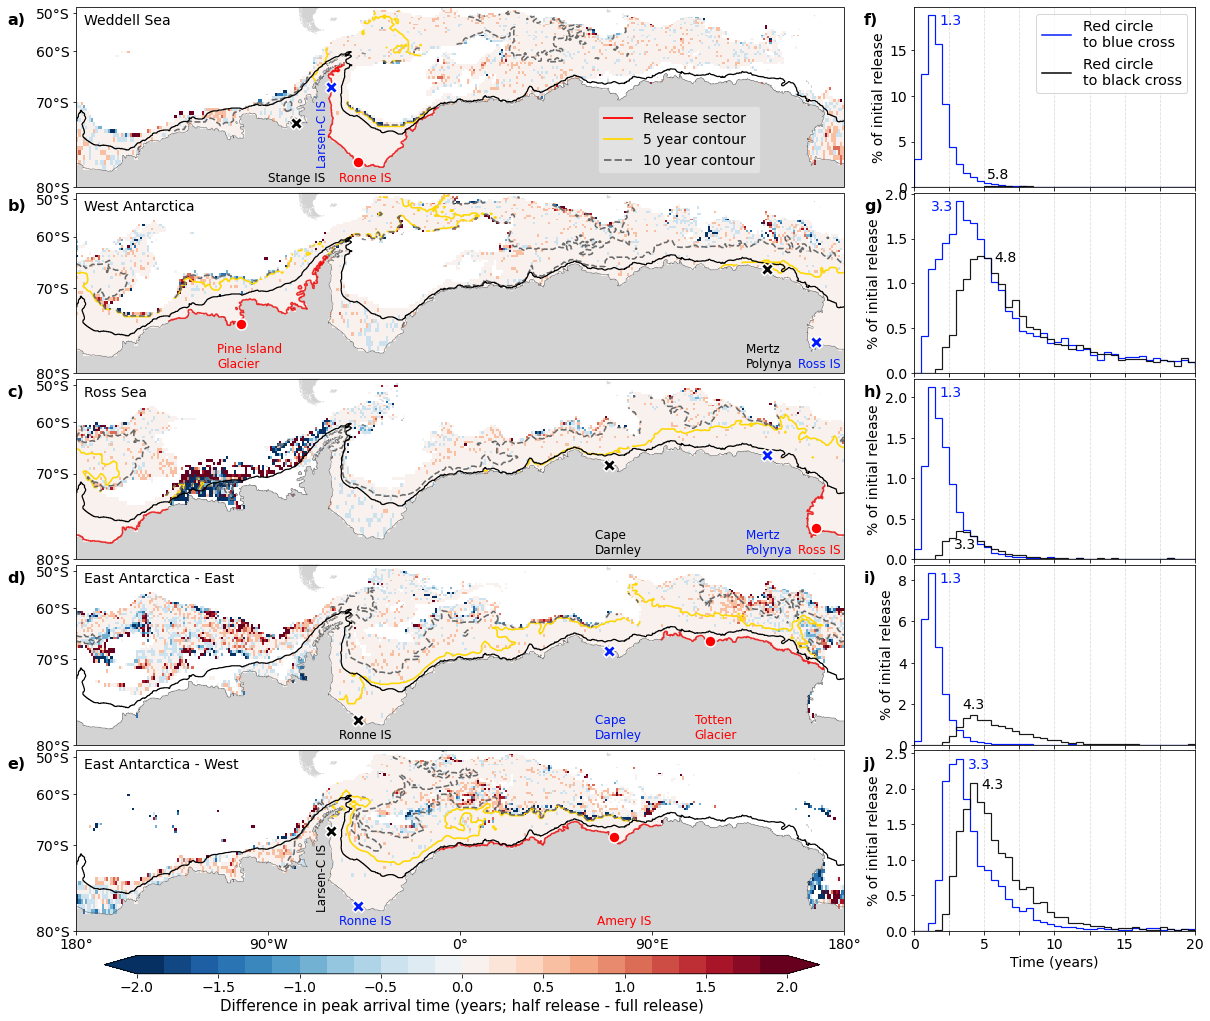

In [96]:
param = 'peak_gaussian'


fig, ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10 = figure(param)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/'
outfile = outdir + 'sensitivityTest_Fig08_timescales_{}_{}_Gamma-20_Ice_halfrelease.jpg'.format(param, basincol)
fig.savefig(outfile, dpi=300, bbox_inches='tight')

plt.show()

## Plot unweighted vs weighted comparison

#### Define figure functions

In [113]:
def mercator_plot(axes, ds, param, pxy, cmap):
    '''
    Return Antarctic Mercator plot on axes
    '''
    
    ds[f'{param}'] = ds[f'{param}'].where(pxy.pxy_trans_pct > 0, np.nan)
       
    axes.set_extent([-179, 180, -80, -48])
    axes.add_feature(land_50m, zorder=1, color='lightgrey')
    axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='k', linewidths=1.2, zorder=3, transform = ccrs.PlateCarree())
    axes.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=1,
                 colors='lightgrey', alpha=1, linewidths=1.2, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=2,
                 colors='dimgrey', alpha=1, linewidths=0.5, transform = ccrs.PlateCarree())
    if param is 'peak_arrival':
        cb = axes.pcolormesh(ds.lon, ds.lat, ds[f'{param}']-ds.peak_gaussian, cmap=cmap, vmin=-2, vmax=2, transform = ccrs.PlateCarree())
    elif param is 'peak_gaussian':
        cb = axes.pcolormesh(ds.lon, ds.lat, ds[f'{param}'], cmap=cmap, vmin=0, vmax=21, transform = ccrs.PlateCarree())
    elif param is 'peak_unweighted_gaussian':
        cb = axes.pcolormesh(ds.lon, ds.lat, ds[f'{param}']-ds.peak_gaussian, cmap=cmap, vmin=-2, vmax=2, transform = ccrs.PlateCarree())
    else:
        cb = axes.pcolormesh(ds.lon, ds.lat, ds[f'{param}']/365, cmap=cmap, vmin=0, vmax=21, transform = ccrs.PlateCarree())
    yticks = [-80, -70, -60, -50]
    axes.set_yticks(yticks, crs=ccrs.PlateCarree())
    axes.yaxis.set_major_formatter(LatitudeFormatter())
    axes.tick_params(axis='y',labelsize=14)
    
    return cb

def figure(param):
    fig = plt.figure(constrained_layout=True, figsize=(21,17))
    spec1 = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)
    ax1 = fig.add_subplot(spec1[0, 0:3], projection=ccrs.Mercator(central_longitude=0))
    ax2 = fig.add_subplot(spec1[0, 3], )
    ax3 = fig.add_subplot(spec1[1,0:3], projection=ccrs.Mercator(central_longitude=0))
    ax4 = fig.add_subplot(spec1[1,3], )
    ax5 = fig.add_subplot(spec1[2,0:3], projection=ccrs.Mercator(central_longitude=0))
    ax6 = fig.add_subplot(spec1[2,3], )
    ax7 = fig.add_subplot(spec1[3,0:3], projection=ccrs.Mercator(central_longitude=0))
    ax8 = fig.add_subplot(spec1[3,3], )
    ax9 = fig.add_subplot(spec1[4,0:3], projection=ccrs.Mercator(central_longitude=0))
    ax10= fig.add_subplot(spec1[4,3], )
    fig.subplots_adjust(wspace=0.06, hspace=0.03)
    
    # plot timemaps  ------------------------- 
    ds = xr.open_dataset(timefiles[0])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[0])
    mercator_plot(ax9, ds, param,pxy, cmap)
    contour_styles = ['-','--']
    ax9.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2], alpha=1, linewidths=lw, linestyles=contour_styles ,transform = ccrs.PlateCarree())
    ds = xr.open_dataset(timefiles[1])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    #ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[1])
    mercator_plot(ax7, ds, param, pxy, cmap)
    ax7.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2], alpha=1, linewidths=lw, linestyles=contour_styles ,transform = ccrs.PlateCarree())
    ds = xr.open_dataset(timefiles[2])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[2])
    mercator_plot(ax5, ds, param, pxy, cmap)
    ax5.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2], alpha=1, linewidths=lw, linestyles=contour_styles ,transform = ccrs.PlateCarree())
    ds = xr.open_dataset(timefiles[3])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[3])
    mercator_plot(ax3, ds, param, pxy, cmap)
    ax3.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2, 'r'], alpha=1, linewidths=lw, linestyles=contour_styles ,transform = ccrs.PlateCarree())
    ds = xr.open_dataset(timefiles[5])
    ds['peak_gaussian'] = ds.peak_gaussian.where(ds.median_arrival <= 0.75*20*365, np.nan) # constrain to timescales <= 15 years
    pxy = xr.open_dataset(pxyfiles[5])
    cb = mercator_plot(ax1, ds, param, pxy, cmap)
    ax1.contour(ds.lon, ds.lat, ds[f'{param}'], [5,10], zorder=2,
                colors=[contourcol1,contourcol2], alpha=1, linewidths=lw, linestyles= contour_styles ,transform = ccrs.PlateCarree())
    
    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.179, 0.09, 0.473, 0.015])
    cbar=fig.colorbar(cb, cax=cbar_ax,orientation='horizontal', extend='both')
    cbar.set_label('Difference in peak arrival time (years; no weighting - transport weighting)', fontsize=15)#, rotation=270)
    cbar.set_ticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])#, rotation=270)
    cbar.ax.tick_params(labelsize=14)

    # add release sector legend ----------------------------
    add_legend(ax1)
    
    # adjust xticks on bottom row --------------------------
    xticks = [-180, -90, 0, 90, 180]
    ax9.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax9.xaxis.set_major_formatter(LongitudeFormatter())
    ax9.tick_params(axis='x',labelsize=14)
    
    # plot release basin contours --------------------------
    contour_release_basin(ax1,ax3,ax5,ax7,ax9)
    
    # Plot transect locations for ttd's --------------------
    lon, lat = plot_transect_locs(ax1, -48)
    ax7.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ax9.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    plot_transect_locs(ax3, -103)
    lon, lat = plot_transect_locs(ax5, 167-360)
    ax3.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    plot_transect_locs(ax7, 117-360)
    lon, lat = plot_transect_locs(ax9, 72)
    lon = 70
    ax7.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ax5.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ids = np.where(ref.lon == 142-360)
    lon, lat = 144, ref.lat[ids].min()
    ax5.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ax3.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ids = np.where(ref.lat == -67.5)
    lon, lat = ref.lon[ids].min(), -67.5
    ax1.scatter(lon, lat, marker='X', s=150, facecolor=cross1,edgecolor=cross1edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ax9.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    ids = np.where(ref.lon == -78)
    lon, lat = -77, ref.lat[ids].min()
    ax1.scatter(lon, lat, marker='X', s=150, facecolor=cross2,edgecolor=cross2edge,linewidth=1.5,zorder=4,transform=ccrs.PlateCarree())
    
    # plot sublabels
    add_subplotlabels(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)

    # plot peak arrival times on histogram panels
    add_peak_arrival_time(ax2,ax4,ax6,ax8,ax10,param)

    # add release loc and destination labels
    add_release_and_destination_labels(ax1,ax3,ax5,ax7,ax9)
    
    # plot transit time distributions ---------------------
    plot_ttd(ax2, df9, df10)
    plot_ttd(ax4, df7, df8)
    plot_ttd(ax6, df5, df6)
    plot_ttd(ax8, df3, df4)
    plot_ttd(ax10, df1, df2)
    ax10.set_xlabel('Time (years)', fontsize=14)
    ax10.tick_params(axis='x',labelsize=14)
    ax10.set_xticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20])
    ax10.set_xticklabels([0, '', 5, '', 10, '', 15,'' , 20])
    ax10.xaxis.grid(True, linestyle='--', c='gainsboro')
    
    # add legend for TTD's
    line1 = Line2D([0], [0], label='Red circle \nto blue cross', color=cross1, alpha=1)
    line2 = Line2D([0], [0], label='Red circle \nto black cross', color=cross2, alpha=1)
    ax2.legend(handles=[line1, line2], fontsize='x-large')
    
    return fig, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10

In [109]:
dffiles = sorted(glob('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/figure07/TTD_*.csv'))

# EA-W
df1 = pd.read_csv(dffiles[0])
df2 = pd.read_csv(dffiles[1])
# EA-E
df3 = pd.read_csv(dffiles[3])
df4 = pd.read_csv(dffiles[2])
# RS
df5 = pd.read_csv(dffiles[4])
df6 = pd.read_csv(dffiles[5])
# WA
df7 = pd.read_csv(dffiles[9])
df8 = pd.read_csv(dffiles[8])
# WS
df9 = pd.read_csv(dffiles[6])
df10 = pd.read_csv(dffiles[7])

#### Plot Figure

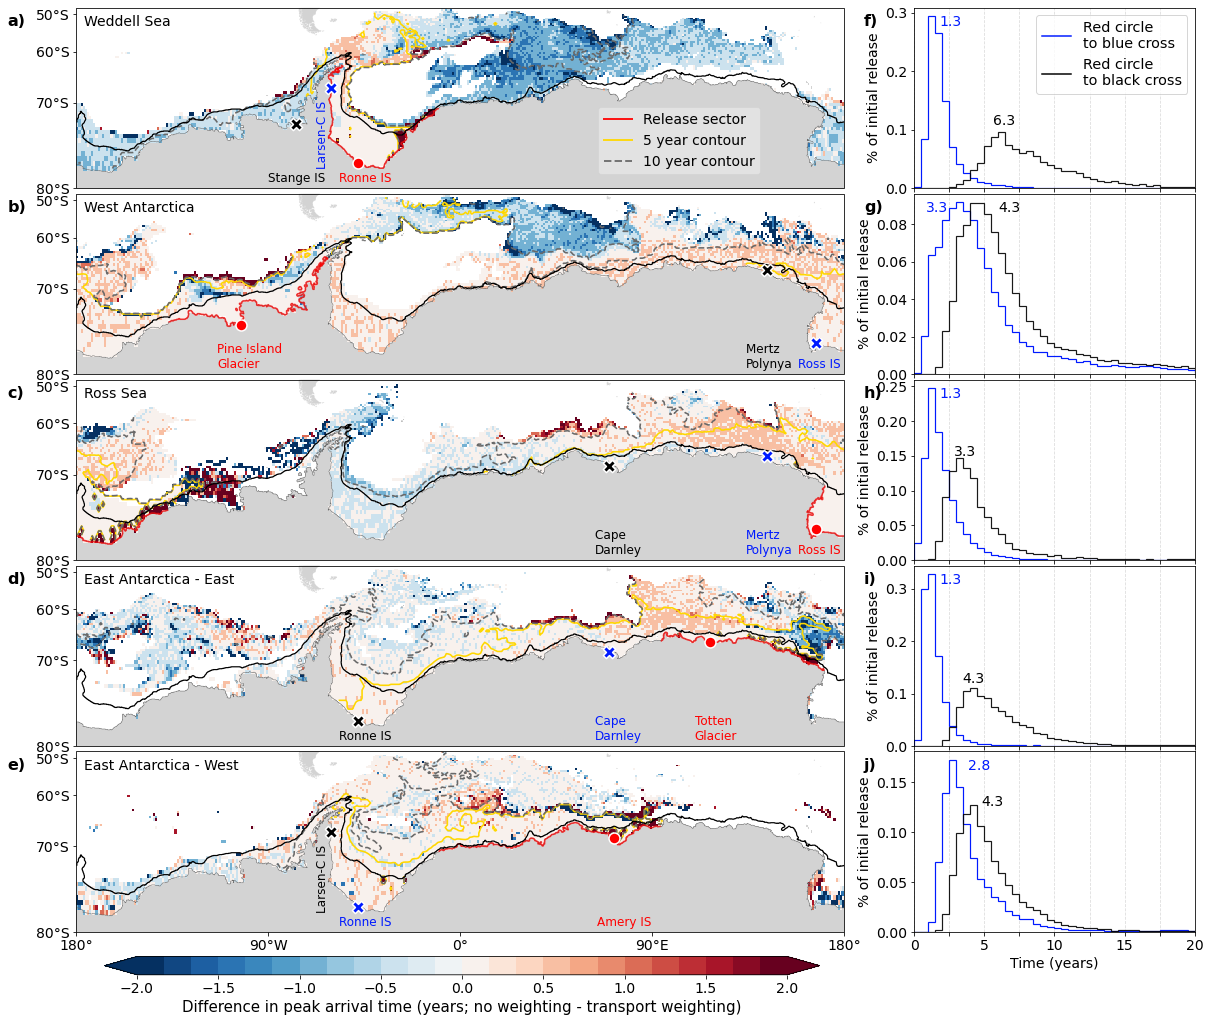

In [114]:
param = 'peak_unweighted_gaussian'

fig, ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10 = figure(param)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'sensitivityTest_Fig08_timescales_{}_{}_Gamma-20_Ice_weighting.jpg'.format(param, basincol)
fig.savefig(outfile, dpi=300, bbox_inches='tight')

plt.show()